# **Import libraries and set up the environment**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib
import warnings
warnings.filterwarnings("ignore")

# For reproducibility
np.random.seed(42)

print("Environment setup complete.")

Environment setup complete.


# **Load and preprocess data**

In [2]:
train_file = 'robo_train.csv'
test_file = 'robo_test.csv'

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

print("Train data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

feature_columns = [f'V{i}' for i in range(1, 25)]
target_column = 'Class'

# Check for missing values
missing_train = df_train[feature_columns].isnull().sum().sum()
missing_test = df_test[feature_columns].isnull().sum().sum()
print(f"Missing in Train: {missing_train}, Missing in Test: {missing_test}")

X_train = df_train[feature_columns]
y_train = df_train[target_column]

X_test = df_test[feature_columns]
y_test = df_test[target_column]

print("Data loading complete.")

Train data shape: (4910, 26)
Test data shape: (546, 26)
Missing in Train: 0, Missing in Test: 0
Data loading complete.


# **Feature Statistics Before Scaling**

In [3]:
print("Feature Statistics Before Scaling:")

feature_stats_before = df_train[feature_columns].describe().T  # Compute mean, std, min, max
display(feature_stats_before)

Feature Statistics Before Scaling:


,count,mean,std,min,25%,50%,75%,max
V1,4910.0,1.471086,0.800140,0.400,0.92200,1.3355,1.80800,5.000
V2,4910.0,2.332688,1.410168,0.437,1.36500,1.9245,2.69575,5.025
V3,4910.0,2.490843,1.248829,0.470,1.53425,2.0675,2.74875,5.029
V4,4910.0,2.799165,1.306564,0.833,1.74150,2.4650,4.09425,5.016
V5,4910.0,2.969249,1.337782,1.120,1.78725,2.6720,4.32850,5.000
V6,4910.0,2.902429,1.279600,1.114,1.79400,2.6965,3.84800,5.005
V7,4910.0,3.360892,1.409547,1.122,1.94100,3.2280,5.00000,5.008
V8,4910.0,2.546102,1.114546,0.859,1.62000,2.1800,3.19375,5.087
V9,4910.0,3.131198,1.358431,0.836,1.80100,2.8030,5.00000,5.000
V10,4910.0,2.833277,1.314111,0.810,1.63300,2.6780,3.55525,5.022


# **Exploratory Data Analysis (EDA)**

Sample of Training Data:


,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,Class
0,3546,1.694,2.642,1.958,1.927,1.920,1.929,2.476,1.973,2.061,...,5.000,1.485,5.000,2.134,0.625,1.692,1.677,1.670,1.680,1
1,3491,0.741,0.766,1.554,1.529,1.523,1.529,5.000,1.568,2.463,...,0.738,0.726,0.732,1.137,0.778,0.739,0.723,0.712,0.722,1
2,2936,0.994,5.000,1.549,1.557,1.510,5.000,5.000,4.024,5.000,...,0.616,0.604,0.612,0.633,0.657,0.981,0.956,0.933,0.938,2
3,2861,0.655,1.318,1.307,1.327,4.196,4.752,5.000,2.857,3.008,...,0.817,1.051,0.884,1.099,0.542,0.554,0.582,0.595,0.626,2
4,3455,0.503,1.385,1.372,1.376,1.426,1.415,2.637,2.633,3.272,...,0.871,1.071,1.075,0.489,0.448,0.435,0.436,0.465,0.489,2


Class Distribution in Training Data:
Class
1    1984
2    1887
4     744
3     295
Name: count, dtype: int64


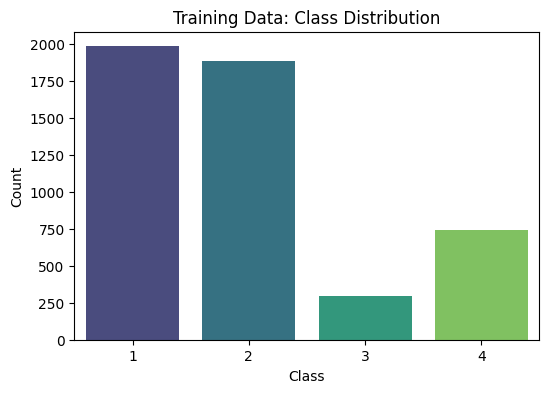

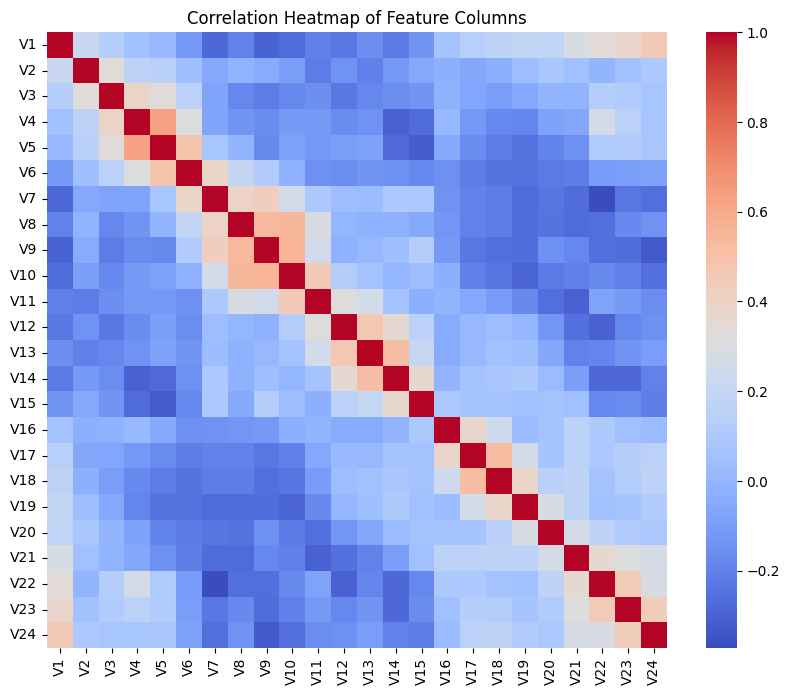




No features high correlation found.
Exploratory Data Analysis complete.


In [4]:
print("Sample of Training Data:")
display(df_train.head())

print("Class Distribution in Training Data:")
print(df_train[target_column].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x=target_column, data=df_train, palette="viridis")
plt.title("Training Data: Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_train[feature_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Feature Columns")
plt.show()

# Check if any features exceed a certain correlation threshold
threshold = 0.9
corr_matrix_abs = corr_matrix.abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

if len(to_drop) == 0:
    print(f"\n\n\nNo features high correlation found.")
else:
    print(f"Features with correlation above {threshold}: {to_drop}")
    # We do NOT remove them, just printing.

print("Exploratory Data Analysis complete.")


# **Define evaluation metrics function**

In [5]:
def compute_metrics(y_true, y_pred):
    """
    Compute and return evaluation metrics in percentages.
    For multiclass problems, we use weighted averages.
    """
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    return accuracy, precision, recall, f1

print("Evaluation metrics function defined.")

Evaluation metrics function defined.


# **Baseline (Pre-Tuning) Evaluation**

In [6]:
def make_pipeline(model):
    """
    Helper function to create a pipeline consisting of:
    1. SimpleImputer (mean strategy)
    2. StandardScaler
    3. The model (estimator) itself
    """
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

# Define baseline models (all defaults)
baseline_models = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier()
}

baseline_results = {}

for model_name, model in baseline_models.items():
    pipeline = make_pipeline(model)  # Create pipeline with scaling
    pipeline.fit(X_train, y_train)   # Train the model
    y_pred = pipeline.predict(X_test)  # Make predictions
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)  # Evaluate

    baseline_results[model_name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

    # 🔹 Check if scaling is applied correctly
    X_train_scaled = pipeline.named_steps['scaler'].transform(X_train)
    df_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)

    print(f"\nFeature Statistics After Scaling for {model_name} (Should have mean ≈ 0 and std ≈ 1):")
    display(df_train_scaled.describe().T)


Feature Statistics After Scaling for SVM (Should have mean ≈ 0 and std ≈ 1):


,count,mean,std,min,25%,50%,75%,max
V1,4910.0,1.403720e-16,1.000102,-1.338760,-0.686308,-0.169471,0.421111,4.410820
V2,4910.0,1.577376e-16,1.000102,-1.344437,-0.686292,-0.289490,0.257486,1.909408
V3,4910.0,-6.367389e-17,1.000102,-1.618355,-0.766070,-0.339026,0.206540,2.032636
V4,4910.0,1.816153e-16,1.000102,-1.504989,-0.809583,-0.255785,0.991315,1.696863
V5,4910.0,8.899873e-17,1.000102,-1.382466,-0.883642,-0.222218,1.016151,1.518153
V6,4910.0,1.063643e-16,1.000102,-1.397789,-0.866319,-0.160949,0.739034,1.643315
V7,4910.0,1.505019e-16,1.000102,-1.588538,-1.007441,-0.094289,1.162980,1.168656
V8,4910.0,-1.519491e-17,1.000102,-1.513867,-0.831008,-0.328510,0.581146,2.279993
V9,4910.0,4.775542e-17,1.000102,-1.689767,-0.979316,-0.241625,1.375847,1.375847
V10,4910.0,-7.669810e-17,1.000102,-1.539812,-0.913469,-0.118174,0.549456,1.665724



Feature Statistics After Scaling for Random Forest (Should have mean ≈ 0 and std ≈ 1):


,count,mean,std,min,25%,50%,75%,max
V1,4910.0,1.403720e-16,1.000102,-1.338760,-0.686308,-0.169471,0.421111,4.410820
V2,4910.0,1.577376e-16,1.000102,-1.344437,-0.686292,-0.289490,0.257486,1.909408
V3,4910.0,-6.367389e-17,1.000102,-1.618355,-0.766070,-0.339026,0.206540,2.032636
V4,4910.0,1.816153e-16,1.000102,-1.504989,-0.809583,-0.255785,0.991315,1.696863
V5,4910.0,8.899873e-17,1.000102,-1.382466,-0.883642,-0.222218,1.016151,1.518153
V6,4910.0,1.063643e-16,1.000102,-1.397789,-0.866319,-0.160949,0.739034,1.643315
V7,4910.0,1.505019e-16,1.000102,-1.588538,-1.007441,-0.094289,1.162980,1.168656
V8,4910.0,-1.519491e-17,1.000102,-1.513867,-0.831008,-0.328510,0.581146,2.279993
V9,4910.0,4.775542e-17,1.000102,-1.689767,-0.979316,-0.241625,1.375847,1.375847
V10,4910.0,-7.669810e-17,1.000102,-1.539812,-0.913469,-0.118174,0.549456,1.665724



Feature Statistics After Scaling for Gradient Boosting (Should have mean ≈ 0 and std ≈ 1):


,count,mean,std,min,25%,50%,75%,max
V1,4910.0,1.403720e-16,1.000102,-1.338760,-0.686308,-0.169471,0.421111,4.410820
V2,4910.0,1.577376e-16,1.000102,-1.344437,-0.686292,-0.289490,0.257486,1.909408
V3,4910.0,-6.367389e-17,1.000102,-1.618355,-0.766070,-0.339026,0.206540,2.032636
V4,4910.0,1.816153e-16,1.000102,-1.504989,-0.809583,-0.255785,0.991315,1.696863
V5,4910.0,8.899873e-17,1.000102,-1.382466,-0.883642,-0.222218,1.016151,1.518153
V6,4910.0,1.063643e-16,1.000102,-1.397789,-0.866319,-0.160949,0.739034,1.643315
V7,4910.0,1.505019e-16,1.000102,-1.588538,-1.007441,-0.094289,1.162980,1.168656
V8,4910.0,-1.519491e-17,1.000102,-1.513867,-0.831008,-0.328510,0.581146,2.279993
V9,4910.0,4.775542e-17,1.000102,-1.689767,-0.979316,-0.241625,1.375847,1.375847
V10,4910.0,-7.669810e-17,1.000102,-1.539812,-0.913469,-0.118174,0.549456,1.665724



Feature Statistics After Scaling for KNN (Should have mean ≈ 0 and std ≈ 1):


,count,mean,std,min,25%,50%,75%,max
V1,4910.0,1.403720e-16,1.000102,-1.338760,-0.686308,-0.169471,0.421111,4.410820
V2,4910.0,1.577376e-16,1.000102,-1.344437,-0.686292,-0.289490,0.257486,1.909408
V3,4910.0,-6.367389e-17,1.000102,-1.618355,-0.766070,-0.339026,0.206540,2.032636
V4,4910.0,1.816153e-16,1.000102,-1.504989,-0.809583,-0.255785,0.991315,1.696863
V5,4910.0,8.899873e-17,1.000102,-1.382466,-0.883642,-0.222218,1.016151,1.518153
V6,4910.0,1.063643e-16,1.000102,-1.397789,-0.866319,-0.160949,0.739034,1.643315
V7,4910.0,1.505019e-16,1.000102,-1.588538,-1.007441,-0.094289,1.162980,1.168656
V8,4910.0,-1.519491e-17,1.000102,-1.513867,-0.831008,-0.328510,0.581146,2.279993
V9,4910.0,4.775542e-17,1.000102,-1.689767,-0.979316,-0.241625,1.375847,1.375847
V10,4910.0,-7.669810e-17,1.000102,-1.539812,-0.913469,-0.118174,0.549456,1.665724


Baseline (Pre-Tuning) Performance on Test Set:


,Accuracy,Precision,Recall,F1 Score
SVM,89.194139,89.313418,89.194139,89.212060
Random Forest,99.450549,99.459271,99.450549,99.451129
Gradient Boosting,99.450549,99.457908,99.450549,99.450116
KNN,87.912088,87.916262,87.912088,87.907903


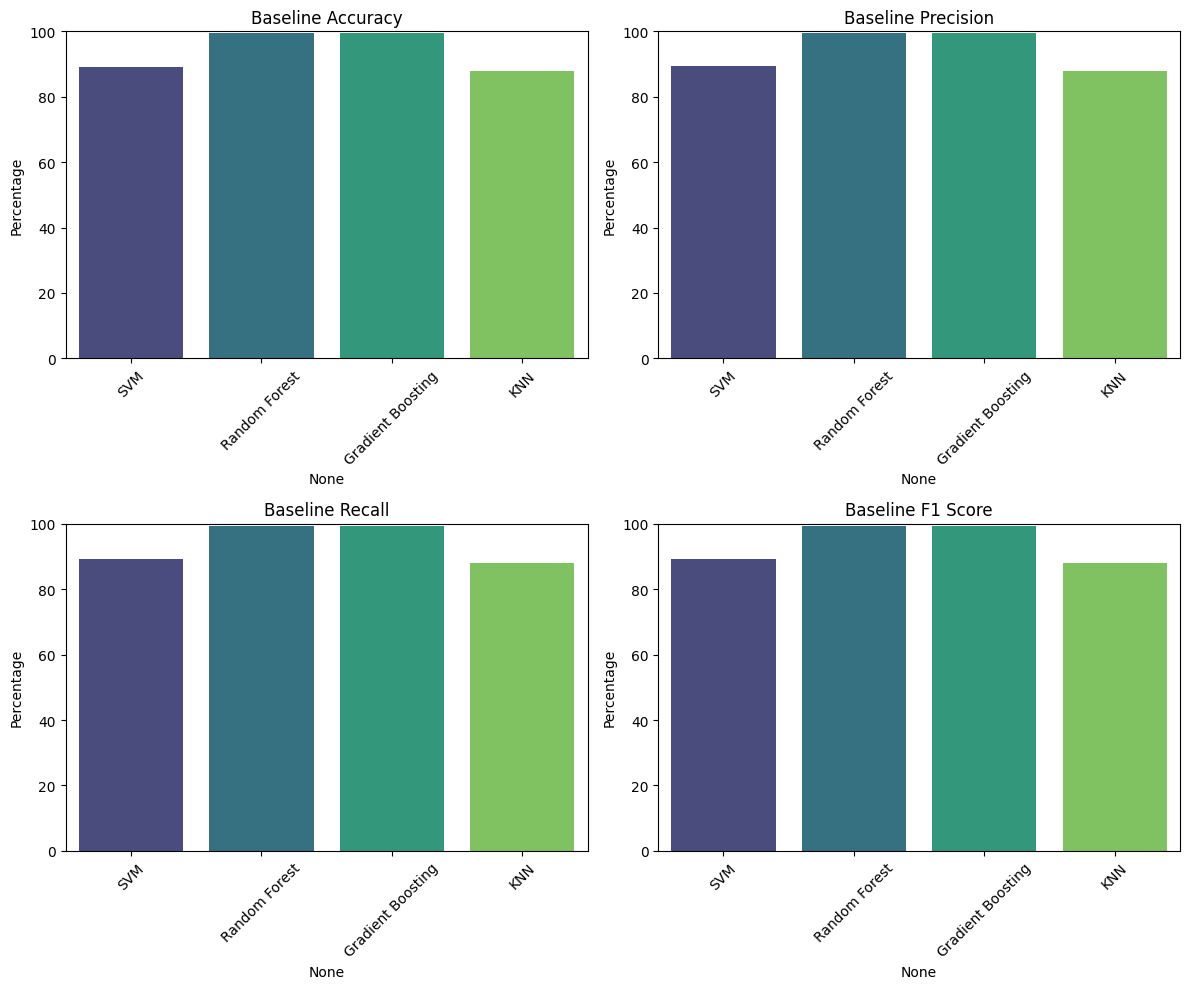

In [7]:
# Convert results to DataFrame
baseline_df = pd.DataFrame(baseline_results).T

print("Baseline (Pre-Tuning) Performance on Test Set:")
display(baseline_df)

# 🔹 Visualization of baseline model performance
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(x=baseline_df.index, y=baseline_df[metric], ax=axs[idx], palette="viridis")
    axs[idx].set_title(f"Baseline {metric}")
    axs[idx].set_ylabel("Percentage")
    axs[idx].set_ylim(0, 100)
    axs[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# **Define grid search tuning and evaluation function**

In [8]:
def tune_and_evaluate(model, param_grid, X_train, y_train, X_test, y_test, cv=5, scoring='f1_weighted'):
    """
    Perform GridSearchCV for the given model within a pipeline that
    imputes missing data, scales features, and then fits the model.
    Returns the best model, its parameters, test metrics, and the GridSearchCV object.
    """
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('estimator', model)
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        refit=True
    )
    grid_search.fit(X_train, y_train)

    best_pipeline = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_pipeline.predict(X_test)
    accuracy, precision, recall, f1 = compute_metrics(y_test, y_pred)
    test_metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

    return best_pipeline, best_params, test_metrics, grid_search

# **Define models, parameter grids, and tune each model**

In [9]:
results = {}

# SVM
svm = SVC(probability=True)
param_grid_svm = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto']
}

# Random Forest
rf = RandomForestClassifier()
param_grid_rf = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5]
}

# Gradient Boosting
gb = GradientBoostingClassifier()
param_grid_gb = {
    'estimator__n_estimators': [100, 200],
    'estimator__learning_rate': [0.01, 0.1],
    'estimator__max_depth': [3, 5]
}

# KNN
knn = KNeighborsClassifier()
param_grid_knn = {
    'estimator__n_neighbors': [3, 5, 7],
    'estimator__weights': ['uniform', 'distance']
}

models_param = {
    'SVM': (svm, param_grid_svm),
    'Random Forest': (rf, param_grid_rf),
    'Gradient Boosting': (gb, param_grid_gb),
    'KNN': (knn, param_grid_knn)
}

for model_name, (model, param_grid) in models_param.items():
    print(f"\nTuning {model_name} ...")
    best_model, best_params, test_metrics, grid_search_obj = tune_and_evaluate(
        model, param_grid, X_train, y_train, X_test, y_test, cv=5
    )
    results[model_name] = {
        'Best Model': best_model,
        'Best Parameters': best_params,
        'Test Metrics': test_metrics,
        'GridSearchCV Object': grid_search_obj
    }
    print(f"{model_name} – Best Parameters: {best_params}")
    print(f"{model_name} – Test Metrics: {test_metrics}")


Tuning SVM ...
SVM – Best Parameters: {'estimator__C': 10, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
SVM – Test Metrics: {'Accuracy': 93.95604395604396, 'Precision': 93.97433025188465, 'Recall': 93.95604395604396, 'F1 Score': 93.9569150810096}

Tuning Random Forest ...
Random Forest – Best Parameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Random Forest – Test Metrics: {'Accuracy': 99.63369963369964, 'Precision': 99.63590626241229, 'Recall': 99.63369963369964, 'F1 Score': 99.63284578669193}

Tuning Gradient Boosting ...
Gradient Boosting – Best Parameters: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 200}
Gradient Boosting – Test Metrics: {'Accuracy': 99.45054945054946, 'Precision': 99.4579081632653, 'Recall': 99.45054945054946, 'F1 Score': 99.45011636682474}

Tuning KNN ...
KNN – Best Parameters: {'estimator__n_neighbors': 3, 'estimator__weights': 'distance'}
KNN – Test 

# **Comparison of DataFrame and bar plot for test metrics**

Comparison of Test Metrics for All Models:


,Accuracy,Precision,Recall,F1 Score
SVM,93.956044,93.974330,93.956044,93.956915
Random Forest,99.633700,99.635906,99.633700,99.632846
Gradient Boosting,99.450549,99.457908,99.450549,99.450116
KNN,89.010989,89.063737,89.010989,89.029900


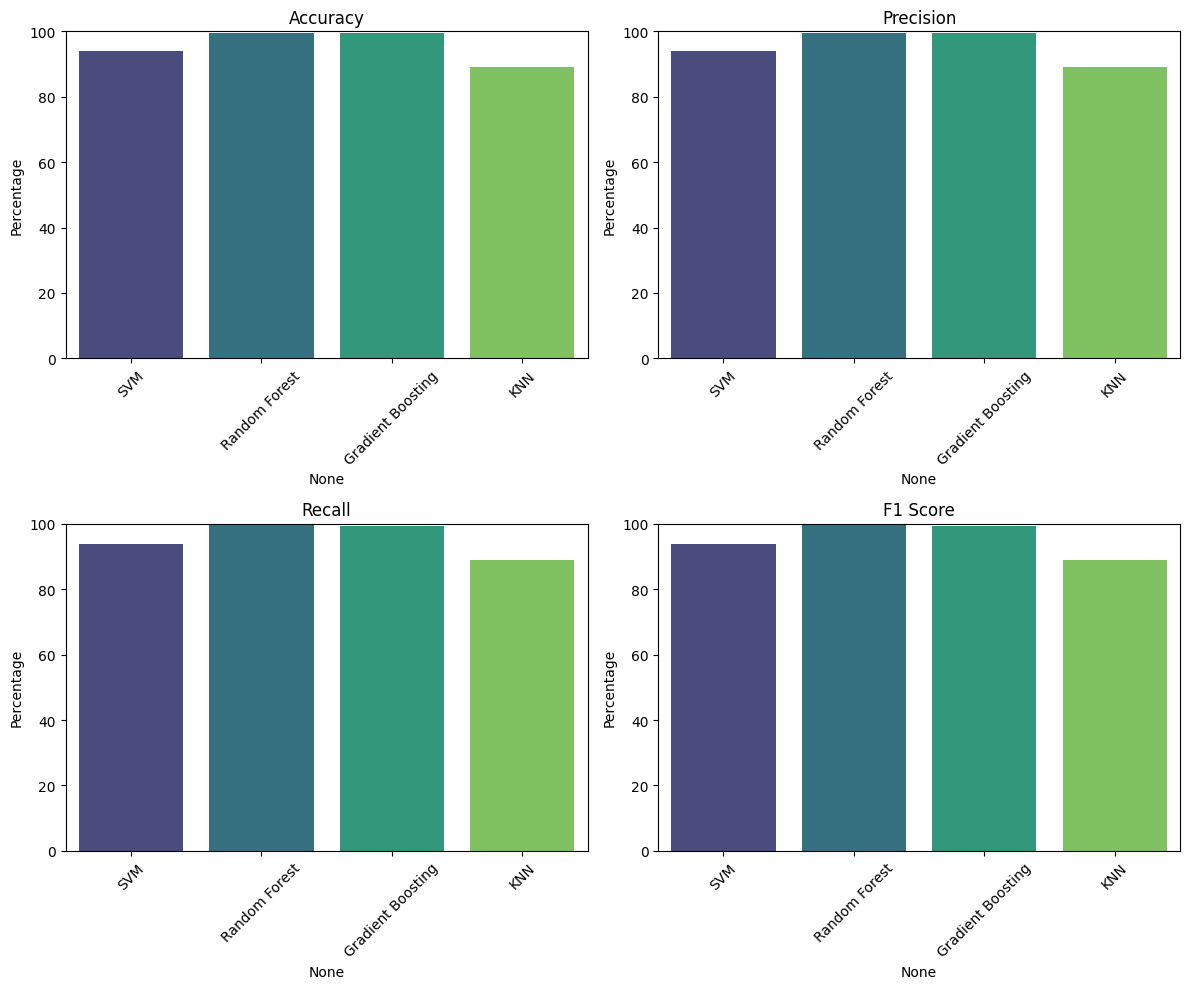

In [10]:
metrics_df = pd.DataFrame({model: results[model]['Test Metrics'] for model in results}).T
print("Comparison of Test Metrics for All Models:")
display(metrics_df)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axs[idx], palette="viridis")
    axs[idx].set_title(metric)
    axs[idx].set_ylabel("Percentage")
    axs[idx].set_ylim(0, 100)
    axs[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# **Identify the best model (highest F1 Score)**

In [11]:
best_model_name = metrics_df['F1 Score'].idxmax()
best_model_info = results[best_model_name]

print(f"Best Model: {best_model_name}")
print("Best Hyperparameters:", best_model_info['Best Parameters'])
print("Test Metrics:", best_model_info['Test Metrics'])

Best Model: Random Forest
Best Hyperparameters: {'estimator__max_depth': 20, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
Test Metrics: {'Accuracy': 99.63369963369964, 'Precision': 99.63590626241229, 'Recall': 99.63369963369964, 'F1 Score': 99.63284578669193}


# **Plot the confusion matrix for the best model**

<Figure size 800x600 with 0 Axes>

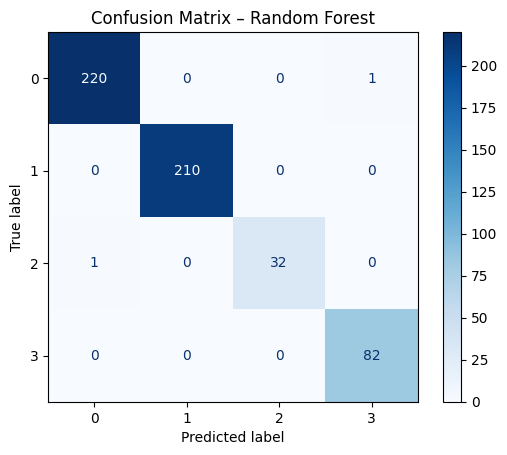

In [12]:
best_model = best_model_info['Best Model']
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# **Baseline vs. Post-Tuning Performance Comparison**

In [13]:
comparison_data = []
for model_name in baseline_df.index:
    base_metrics = baseline_df.loc[model_name]
    tuned_metrics = metrics_df.loc[model_name]

    comparison_data.append({
        'Model': model_name,
        'Accuracy (Baseline)': base_metrics['Accuracy'],
        'Accuracy (Tuned)': tuned_metrics['Accuracy'],
        'Precision (Baseline)': base_metrics['Precision'],
        'Precision (Tuned)': tuned_metrics['Precision'],
        'Recall (Baseline)': base_metrics['Recall'],
        'Recall (Tuned)': tuned_metrics['Recall'],
        'F1 (Baseline)': base_metrics['F1 Score'],
        'F1 (Tuned)': tuned_metrics['F1 Score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Baseline vs. Tuned Performance Comparison:")
display(comparison_df)

Baseline vs. Tuned Performance Comparison:


,Model,Accuracy (Baseline),Accuracy (Tuned),Precision (Baseline),Precision (Tuned),Recall (Baseline),Recall (Tuned),F1 (Baseline),F1 (Tuned)
0,SVM,89.194139,93.956044,89.313418,93.974330,89.194139,93.956044,89.212060,93.956915
1,Random Forest,99.450549,99.633700,99.459271,99.635906,99.450549,99.633700,99.451129,99.632846
2,Gradient Boosting,99.450549,99.450549,99.457908,99.457908,99.450549,99.450549,99.450116,99.450116
3,KNN,87.912088,89.010989,87.916262,89.063737,87.912088,89.010989,87.907903,89.029900


# **Feature Importance (where applicable)**



 No feature importance or coefficients to plot for SVM.


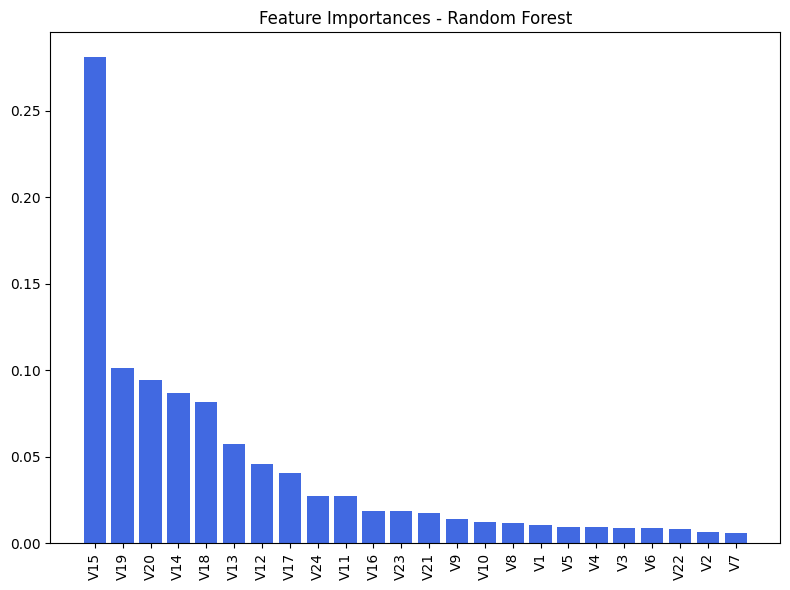

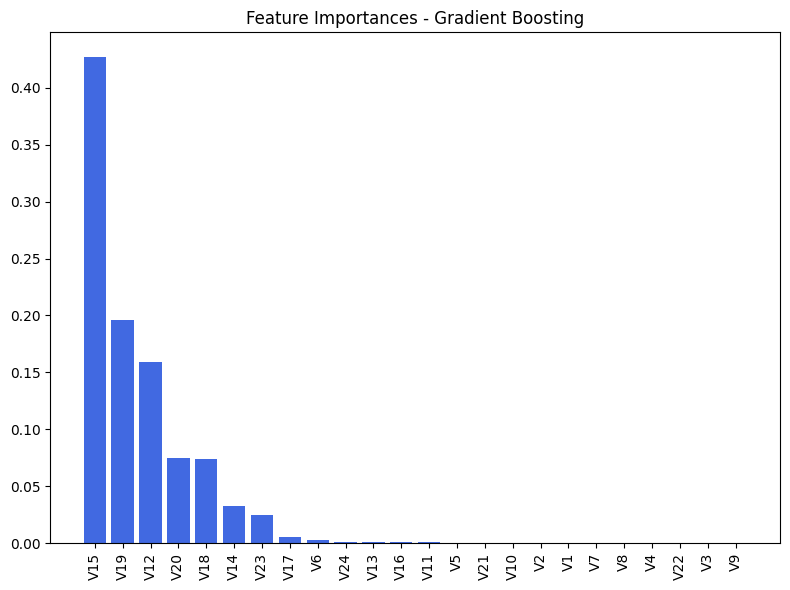



 No feature importance or coefficients to plot for KNN.


In [14]:
for model_name, info in results.items():
    best_estimator = info['Best Model']

    # Tree-based model
    if hasattr(best_estimator[-1], 'feature_importances_'):
        importances = best_estimator[-1].feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 6))
        plt.bar(range(len(importances)), importances[indices], color='royalblue')
        plt.xticks(range(len(importances)), [feature_columns[i] for i in indices], rotation=90)
        plt.title(f"Feature Importances - {model_name}")
        plt.tight_layout()
        plt.show()

    else:
        print(f"\n\n No feature importance or coefficients to plot for {model_name}.")

# **Learning Curve for the Best Model**

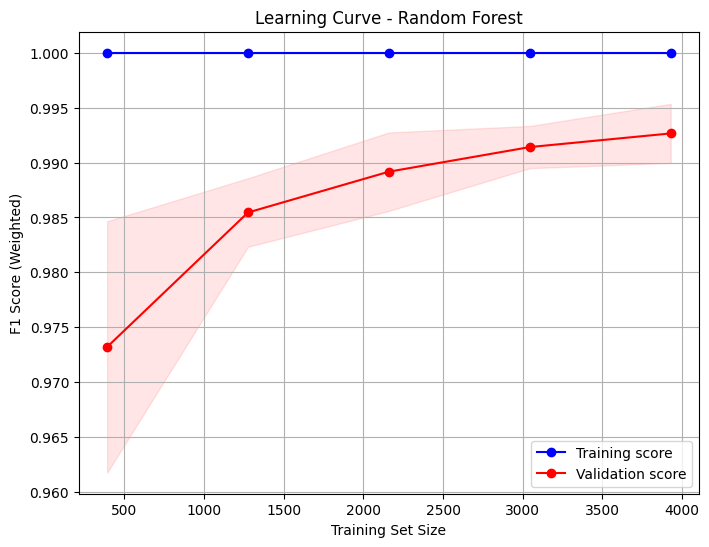

In [15]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='red', label='Validation score')

plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes,
                 test_mean - test_std,
                 test_mean + test_std,
                 alpha=0.1, color='red')

plt.title(f"Learning Curve - {best_model_name}")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score (Weighted)")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# **Inspect the grid search results for the best model**

In [16]:
grid_results = best_model_info['GridSearchCV Object'].cv_results_
params_df = pd.DataFrame(grid_results['params'])
params_df['Mean Test Score'] = grid_results['mean_test_score']
params_df['Std Test Score'] = grid_results['std_test_score']

print("Top 5 Grid Search Results for the Best Model:")
display(params_df.sort_values(by='Mean Test Score', ascending=False).head())

Top 5 Grid Search Results for the Best Model:


,estimator__max_depth,estimator__min_samples_split,estimator__n_estimators,Mean Test Score,Std Test Score
10,20.0,5,100,0.993262,0.001780
8,20.0,2,100,0.992862,0.002140
3,NaN,5,200,0.992859,0.002657
1,NaN,2,200,0.992857,0.002234
9,20.0,2,200,0.992851,0.002328


# **Save the performance results and best model**

In [17]:
results_json = {}
for model in results:
    results_json[model] = {
        'Best Parameters': results[model]['Best Parameters'],
        'Test Metrics': results[model]['Test Metrics']
    }

with open('model_performance.json', 'w') as f:
    json.dump(results_json, f, indent=4)

print("Performance results saved to 'model_performance.json'.")

# Save best model
joblib.dump(best_model, f"{best_model_name}_best_model.pkl")
print(f"Best model saved to {best_model_name}_best_model.pkl")

Performance results saved to 'model_performance.json'.
Best model saved to Random Forest_best_model.pkl


# **Result**

In [18]:
print("Model comparison complete.")
print("The best model based on F1 Score is:", best_model_name)

Model comparison complete.
The best model based on F1 Score is: Random Forest
